In [12]:
using Pkg
Pkg.activate("..")
# GQ was removed since it has too few intersecting tokens
# adds ALL 
VALID_CC = ["ALL", "AR", "BO", "BR", "CA", "CL", "CO", "CR", "CU", "DO", "EC", "ES", "FR", "GB", "GT", "HN", "MX", "NI", "PA", "PE", "PR", "PY", "SV", "US", "UY", "VE"]
using SimilaritySearch, SimSearchManifoldLearning, TextSearch, LinearAlgebra, HDF5, JSON, JLD2, CSV, DataFrames, Glob, StatsBase, Plots

  Activating project at `~/Research/RegionalSpanish`


In [7]:
edir = "../data/SpanishLang/embeddings"
k = 33
common = CSV.read("../data/SpanishLang/voc/ALL.tsv.gz", DataFrame, delim='\t')
subset!(common, :n_regions => n -> n .>= 10)

Row,token,occs,ndocs,weight,n_regions,country_codes
,String,Int64,Int64,Float64,Int64,String
1,fueron,1007329,986267,8.65527,25,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE
2,",",198582423,133250538,1.57732,26,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GQ:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE
3,salir,2821137,2755970,7.17276,26,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GQ:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE
4,pero,29588164,28784422,3.78811,26,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GQ:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE
5,dormir,3754460,3646554,6.76879,26,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GQ:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE
6,las,35857087,32046472,3.63323,26,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GQ:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE
7,chau,409398,387910,10.0015,25,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE
8,siento,2830971,2764088,7.16852,26,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GQ:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE
9,ganas,4624814,4534858,6.45426,26,AR:BO:BR:CA:CL:CO:CR:CU:DO:EC:ES:FR:GB:GQ:GT:HN:MX:NI:PA:PE:PR:PY:SV:US:UY:VE


In [8]:
function encode_model(knns, dists, vocab)
    #vocab = Symbol.(vocab)
    #  ivocab = Dict(token => i for (i, token) in enumerate(vocab))
    obj = Dict{UInt64,Float64}()
    for (i, (idcol, distcol)) in enumerate(zip(eachcol(knns), eachcol(dists)))
        for j in eachindex(idcol, distcol)
            w = (vocab[i], vocab[idcol[j]])
            s = hash(w)
            obj[s] = 1.0 + 1 / (1 + distcol[j])
        end
    end
 
    normalize!(obj)
end

encode_model (generic function with 1 method)

In [ ]:
db = []

for cc in VALID_CC
    modelname = only(glob(joinpath(edir, "knns-common-tokens.cc=$cc*.h5")))
    @info modelname
    knns_, dists_, vocab_ = load(modelname, "knns", "dists", "vocab")
    push!(db, encode_model(knns_, dists_, vocab_))
end

length(db)

┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=ALL-1.7m.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=AR.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=BO.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=BR.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CA.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CL.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CO.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CR.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CU.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=DO.k=33.h5
└ @ Main In[10]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=EC.k=33.h5
└ @ Main In[10]:5
┌ In

In [17]:
dist = NormalizedCosineDistance()
n = length(VALID_CC)
A = Matrix{Float64}(undef, n, n)

for (i, cc) in enumerate(VALID_CC)
    u = db[i]
    A[i, i] = 0.0
    @time for j in i+1:n
        v = db[j]
        A[j, i] = A[i, j] = evaluate(dist, u, v)
    end
end

  2.498507 seconds (51 allocations: 1.203 KiB)
  2.372532 seconds (49 allocations: 1.156 KiB)
  1.370643 seconds (47 allocations: 1.109 KiB)
  1.651396 seconds (45 allocations: 1.062 KiB)
  1.414007 seconds (43 allocations: 1.016 KiB)
  2.040701 seconds (42 allocations: 1024 bytes)
  1.952215 seconds (39 allocations: 944 bytes)
  1.579027 seconds (37 allocations: 896 bytes)
  0.460287 seconds (35 allocations: 848 bytes)
  1.456836 seconds (33 allocations: 800 bytes)
  1.487155 seconds (31 allocations: 752 bytes)
  1.433336 seconds (30 allocations: 736 bytes)
  0.920989 seconds (27 allocations: 656 bytes)
  0.904013 seconds (25 allocations: 608 bytes)
  0.864792 seconds (23 allocations: 560 bytes)
  0.660468 seconds (21 allocations: 512 bytes)
  0.965833 seconds (19 allocations: 464 bytes)
  0.541601 seconds (17 allocations: 416 bytes)
  0.676697 seconds (15 allocations: 368 bytes)
  0.616085 seconds (13 allocations: 320 bytes)
  0.172787 seconds (11 allocations: 272 bytes)
  0.422385 s

In [18]:
function creatergb!(C)
    for i in (1, 2, 3)
        v = @view C[i, :]
        # s = 4 * std(v)
        min_, max_ = extrema(v)
        # v .= v ./ s .+ 0.5

        for j in eachindex(v)
            x = (v[j] - min_) / (max_ - min_)
            v[j] = clamp(x,  0, 0.95)
        end
    end

    [RGB(c...) for c in eachcol(C)]
end

creatergb! (generic function with 1 method)

  0.000170 seconds (3 allocations: 1.062 KiB)
  0.000007 seconds (3 allocations: 1.062 KiB)


┌ Info: ======= k=4 =====
└ @ Main In[24]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 3.5855e-5
- embedding init: 0.000619291
- embedding opt: 0.003886563

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 3.5247e-5
- embedding init: 0.000565696
- embedding opt: 0.001823729

┌ Info: (:r, :g, :b)
└ @ Main In[24]:35


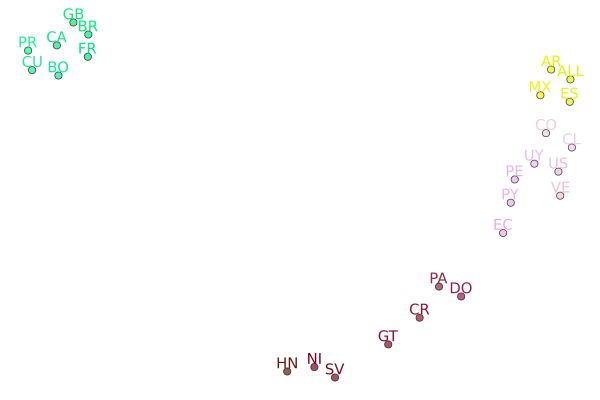

  0.000064 seconds (6 allocations: 7.812 KiB)
  0.000006 seconds (3 allocations: 1.531 KiB)


┌ Info: ======= k=6 =====
└ @ Main In[24]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 4.7494e-5
- embedding init: 0.000398082
- embedding opt: 0.006160439

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 4.5584e-5
- embedding init: 0.000380919
- embedding opt: 0.00389714

┌ Info: (:r, :g, :b)
└ @ Main In[24]:35


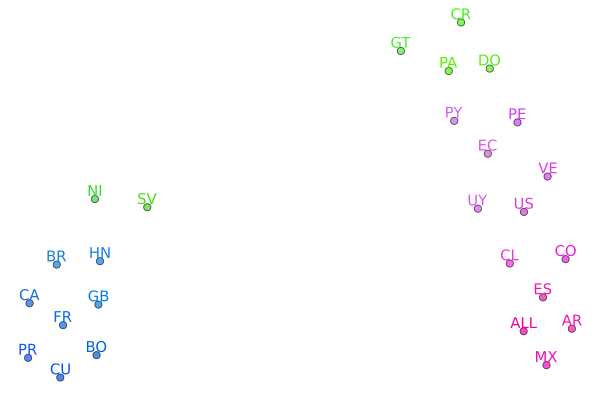

  0.000167 seconds (3 allocations: 1.844 KiB)
  0.000046 seconds (3 allocations: 1.844 KiB)


┌ Info: ======= k=8 =====
└ @ Main In[24]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.2965e-5
- embedding init: 0.000423257
- embedding opt: 0.005586155

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.2724e-5
- embedding init: 0.000424079
- embedding opt: 0.010596856

┌ Info: (:r, :g, :b)
└ @ Main In[24]:35


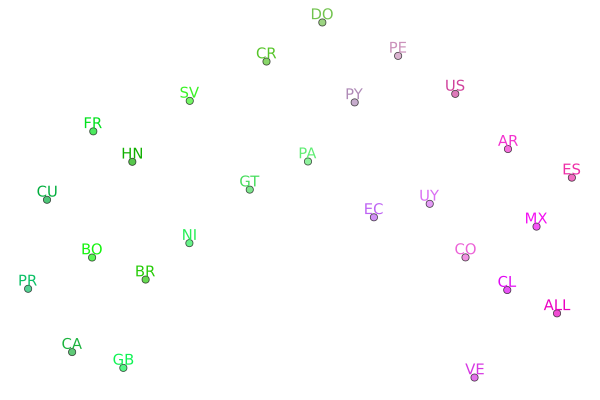

  0.000159 seconds (3 allocations: 2.375 KiB)
  0.000008 seconds (3 allocations: 2.375 KiB)


┌ Info: ======= k=10 =====
└ @ Main In[24]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.6139e-5
- embedding init: 0.000388849
- embedding opt: 0.009121943

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.3434e-5
- embedding init: 0.000362708
- embedding opt: 0.00476312

┌ Info: (:r, :g, :b)
└ @ Main In[24]:35


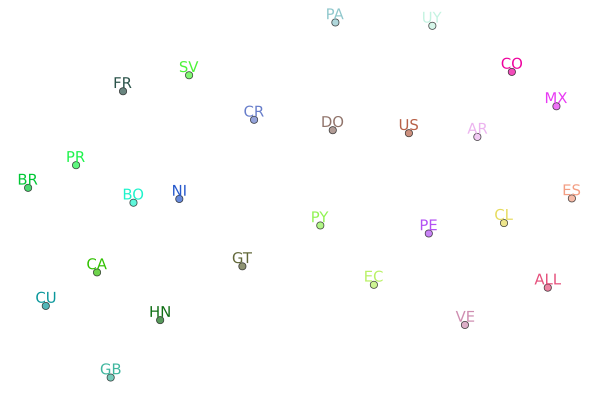

  0.000160 seconds (3 allocations: 2.750 KiB)


┌ Info: ======= k=12 =====
└ @ Main In[24]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding


  0.000011 seconds (3 allocations: 2.750 KiB)


UMAP construction time cost report:
- fuzzy graph: 6.3327e-5
- embedding init: 0.000340227
- embedding opt: 0.008480114

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 6.0074e-5
- embedding init: 0.000347222
- embedding opt: 0.006375385

┌ Info: (:r, :g, :b)
└ @ Main In[24]:35


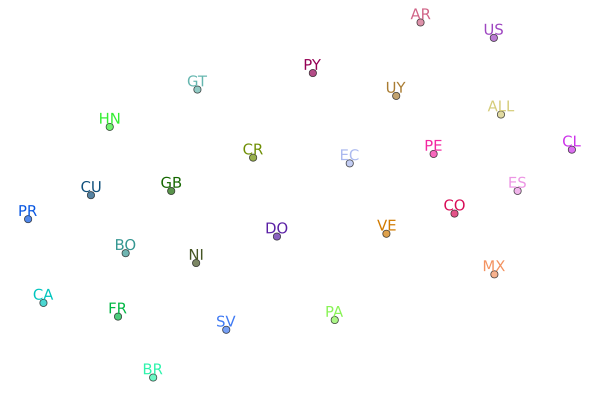

In [24]:
min_dist = 0.3
neg_sample_rate = 5
local_connectivity = 1
layout = SpectralLayout()
n_epochs = 100
tol = 1e-4

for k in 4:2:12
    @info "======= k=$k ====="
    U2 = fit(UMAP, PrecomputedAffinityMatrix(A); maxoutdim=2,
            layout, k, local_connectivity, neg_sample_rate, min_dist, n_epochs, tol)

    U3 = fit(UMAP, PrecomputedAffinityMatrix(A); maxoutdim=3,
            layout, k, local_connectivity, neg_sample_rate, min_dist, n_epochs, tol)

    X = predict(U2)
    C = creatergb!(predict(U3))
    #C .= C .+ 5

    #poslist = rand([:right, :left, :bottom, :top], length(cclist))
    poslist = rand([:bottom], length(VALID_CC))

    scatter(X[1, :], X[2, :], c=C, label="",
        series_annotations=[text(VALID_CC[i], poslist[i], 10, C[i]) for i in eachindex(VALID_CC)],
        xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
        ms=4, ma=0.7, fa=0.7,
        la=0.7,
        alpha=0.7
    )
    #scatter!(X[1, :], X[2, :], c=C, label="",
    #    series_annotations=[text(cclist[i], poslist[i], 10, C[i]) for i in eachindex(cclist)], xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
    #    ms=5, ma=0.5, fa=0.5, la=0.5, alpha=0.5)
    savefig("../figs/fig-voc-semantic-umap-$k.pdf")
    savefig("../figs/fig-voc-semantic-umap-$k.png")
    @info fieldnames(typeof(C[1]))
    open(joinpath(edir, "colormap-common-voc-semantic-$k.csv"), "w") do f
        println(f, "country,R,G,B")
        for (i, (cc, c)) in enumerate(zip(VALID_CC, C))
            println(f, cc, ",", c.r, ",", c.g, ",", c.b)
        end
    end
    
    plot!(fmt=:png) |> display
end



In [10]:
#=D = Dict(zip(cclist, db))
@show [
evaluate(dist, D["MX"], D["MX"])
evaluate(dist, D["MX"], D["ALL"])
evaluate(dist, D["MX"], D["SV"])
evaluate(dist, D["ES"], D["GQ"])
]

@info D["MX"][:iglesia]
@info D["US"][:iglesia]
=#

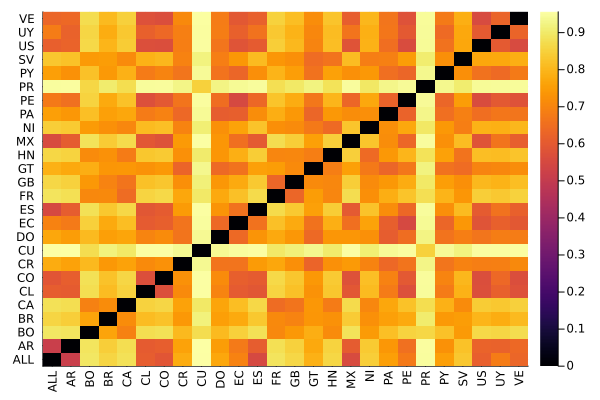

In [27]:
#heatmap(cclist, cclist, A, ticks = :all, xrot=90)
heatmap(VALID_CC, VALID_CC, A, ticks = :all, xrot=90)
savefig("../figs/fig-common-words-semantic-affinity-matrix.pdf")
savefig("../figs/fig-common-words-semantic-affinity-matrix.png")
plot!(fmt=:png)